# Problem Set 4: Hybrid Optimization

AI 211 | 2nd Sem AY 2023-2024

Students:  
Joshua Cantor  
Michael Spencer Quinto


In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import timeit

The Bohachevsky Function 1st variant is a commonly used test function in optimization, notable
for its simplicity yet challenging landscape. The function is defined as:

f1(x, y) = x2 + 2y2 − 0.3cos(3πx) − 0.4cos(4πy) + 0.7

Graph is also shown in 3D below.

In [3]:
# Define Bohachevsky function f1 and its gradient
def f1(x, y):
    return x**2 + 2*y**2 - 0.3*np.cos(3*np.pi*x) - 0.4*np.cos(4*np.pi*y) + 0.7

def grad_f1(x, y):
    df_dx = 2*x + 0.9*np.pi*np.sin(3*np.pi*x)
    df_dy = 4*y + 1.6*np.pi*np.sin(4*np.pi*y)
    return np.array([df_dx, df_dy])

def hessian_f1(x, y):
    d2f_dx2 = 2 + 2.7*(np.pi**2)*np.cos(3*np.pi*x)
    d2f_dy2 = 4 + 6.4*(np.pi**2)*np.cos(4*np.pi*y)
    d2f_dxdy = 0
    return np.array([[d2f_dx2, d2f_dxdy], [d2f_dxdy, d2f_dy2]])

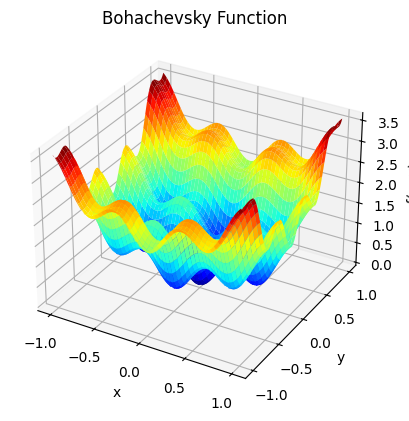

In [19]:
# Create a grid of points
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)

# Plot the function in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')
plt.title('Bohachevsky Function')
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('f(x, y)')
plt.show()

# Trust Region Newton method 

The Trust Region Newton method is an optimization algorithm that balances between local quadratic approximations and global models to efficiently handle complex, non-linear functions. By iteratively adjusting the size of the trust region, it ensures robust convergence to optimal solutions even in challenging problem spaces.

In [12]:
# Trust region method
def trust_region_step(grad, hess, delta=1.0):
    try:
        p = -np.linalg.inv(hess).dot(grad)
    except np.linalg.LinAlgError:
        p = -grad
    if np.linalg.norm(p) > delta:
        p = delta * p / np.linalg.norm(p)
    return p

In [13]:
# Steepest Descent with Armijo's Rule
def newton_method(f, grad_f, hessian_f, x0, tol=1e-6, max_iter=1000):
    x_k = np.array(x0)
    path = [x_k.copy()]
    function_evals = 0
    gradient_evals = 0
    for k in range(max_iter):
        grad_k = grad_f(x_k[0], x_k[1])
        gradient_evals += 1
        if np.linalg.norm(grad_k) < tol or np.isnan(np.linalg.norm(grad_k)):
            break
        hess = hessian_f(x_k[0], x_k[1])
        epsilon_k = trust_region_step(grad_k, hess)
        x_k = x_k + (x_k * epsilon_k)
        function_evals += 1
        path.append(x_k.copy())
    return np.array(path), function_evals, gradient_evals

# Steepest Descent with Armijo's Rule


The Steepest Descent method with Armijo's Rule is a gradient-based optimization technique that ensures efficient convergence by adjusting the step size according to a specific condition. Armijo's Rule dynamically scales the step size to guarantee sufficient decrease in the objective function, improving stability and performance in finding minima.

In [11]:
# Armijo's rule for backtracking line search
def armijo_rule(f, grad_f, x, d_k, epsilon_0=1, beta=0.5, sigma=10**(-4)):
    fx = f(x[0], x[1])
    grad_fx = grad_f(x[0], x[1])
    epsilon = epsilon_0
    while True:
        if f(x[0] + epsilon * d_k[0], x[1] + epsilon * d_k[1]) <= fx + sigma * epsilon * np.dot(grad_fx, d_k):
            break
        epsilon *= beta
    return epsilon

In [14]:
# Steepest Descent with Armijo's Rule
def steepest_descent(f, grad_f, x0, tol=1e-6, max_iter=1000):
    x_k = np.array(x0)
    path = [x_k.copy()]
    function_evals = 0
    gradient_evals = 0
    for k in range(max_iter):
        grad_k = grad_f(x_k[0], x_k[1])
        gradient_evals += 1
        if np.linalg.norm(grad_k) < tol or np.isnan(np.linalg.norm(grad_k)):
            break
        d_k = -grad_k
        epsilon_k = armijo_rule(f, grad_f, x_k, d_k)   ## change this to Armijo
        x_k = x_k + (epsilon_k * d_k)
        function_evals += 1
        path.append(x_k.copy())
    return np.array(path), function_evals, gradient_evals

# Hybrid Method

The Hybrid Method combines the Trust Region Newton method with the Steepest Descent method incorporating Armijo's Rule to leverage the strengths of both approaches. This hybrid approach utilizes the robust local convergence properties of the Trust Region Newton method while integrating the global search capabilities of the Steepest Descent method. By dynamically adjusting between these methods based on the problem's characteristics, it ensures efficient and stable convergence even for complex, non-linear optimization problems. The integration of Armijo's Rule further enhances the step size control, ensuring adequate progress at each iteration.

In [15]:
# Hybrid method
def hybrid_method(f, grad_f, hessian_f, x0, use_armijo=False, tol=1e-6, max_iter=1000):
    x_k = np.array(x0)
    path = [x_k.copy()]
    function_evals = 0
    gradient_evals = 0
    for k in range(max_iter):
        grad_k = grad_f(x_k[0], x_k[1])
        gradient_evals += 1
        if np.linalg.norm(grad_k) < tol or np.isnan(np.linalg.norm(grad_k)):
            break
        d_k = -grad_k
        if use_armijo:
            epsilon_k = armijo_rule(f, grad_f, x_k, d_k, 0.3)
            x_k = x_k + (epsilon_k * d_k)
        else:
            hess = hessian_f(x_k[0], x_k[1])
            epsilon_k = trust_region_step(grad_k, hess)
            x_k = x_k + (x_k * epsilon_k)
            use_armijo=True
        function_evals += 1
        path.append(x_k.copy())
    return np.array(path), function_evals, gradient_evals

## Results and Graphs both in 2D and 3D

The plot and the evaluation data provided a comparative analysis of three optimization methods
applied to the Bohachevsky function (first function):

- Trust Region Newton method
- Steepest Descent with Armijo’s Rule
- Hybrid Method

The results demonstrate the performance and efficiency of each method in terms of path taken,
computation time, and the number of function and gradient evaluations

Trust Region Newton method: Time=0.0468723000s, Function Evals=1000, Gradient Evals=1000
Steepest Descent with Armijo's Rule: Time=0.0007120000s, Function Evals=26, Gradient Evals=27
Hybrid Method: Time=0.0006885000s, Function Evals=16, Gradient Evals=17


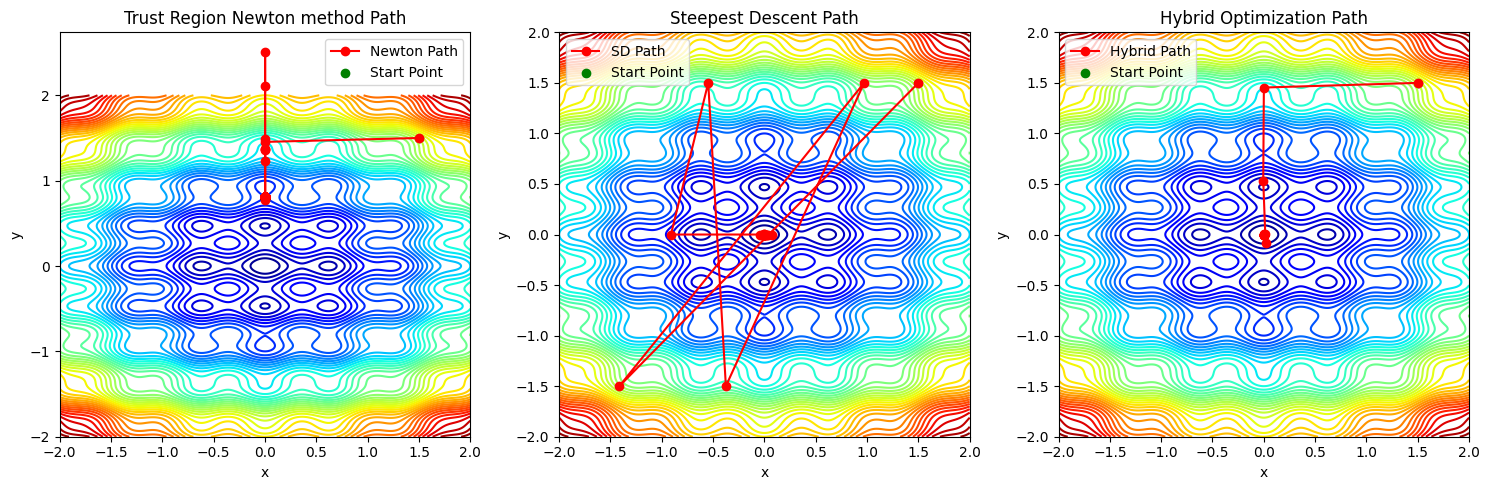

In [20]:
# Initial point
x0 = np.array([1.5, 1.5])

# Plot the results
X, Y = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
Z = f1(X, Y)

# Measure and run newton method
st_newton = timeit.default_timer()
path_newton, fevals_newton, gevals_newton = newton_method(f1, grad_f1, hessian_f1, x0)
time_newton = timeit.default_timer() - st_newton

# Measure and run Steepest Descent with Armijo's Rule
st_sd_armijo = timeit.default_timer()
path_sd_armijo, fevals_sd_armijo, gevals_sd_armijo = steepest_descent(f1, grad_f1, x0)
time_sd_armijo = timeit.default_timer() - st_sd_armijo

# Measure and run Hybrid Method
st_hybrid = timeit.default_timer()
path_sd_hybrid, fevals_sd_hybrid, gevals_sd_hybrid = hybrid_method(f1, grad_f1, hessian_f1, x0, use_armijo=False)
time_sd_hybrid = timeit.default_timer() - st_hybrid

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.contour(X, Y, Z, levels=50, cmap='jet')
plt.plot(path_newton[:, 0], path_newton[:, 1], 'ro-', label='Newton Path')
plt.scatter(x0[0], x0[1], color='green', label='Start Point')
plt.title('Trust Region Newton method Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1, 3, 2)
plt.contour(X, Y, Z, levels=50, cmap='jet')
plt.plot(path_sd_armijo[:, 0], path_sd_armijo[:, 1], 'ro-', label='SD Path')
plt.scatter(x0[0], x0[1], color='green', label='Start Point')
plt.title('Steepest Descent Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1, 3, 3)
plt.contour(X, Y, Z, levels=50, cmap='jet')
plt.plot(path_sd_hybrid[:, 0], path_sd_hybrid[:, 1], 'ro-', label='Hybrid Path')
plt.scatter(x0[0], x0[1], color='green', label='Start Point')
plt.title('Hybrid Optimization Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

print(f"Trust Region Newton method: Time={time_newton:.10f}s, Function Evals={fevals_newton}, Gradient Evals={gevals_newton}")
print(f"Steepest Descent with Armijo's Rule: Time={time_sd_armijo:.10f}s, Function Evals={fevals_sd_armijo}, Gradient Evals={gevals_sd_armijo}")
print(f"Hybrid Method: Time={time_sd_hybrid:.10f}s, Function Evals={fevals_sd_hybrid}, Gradient Evals={gevals_sd_hybrid}")

plt.tight_layout()
plt.show()

## Graph in 3D

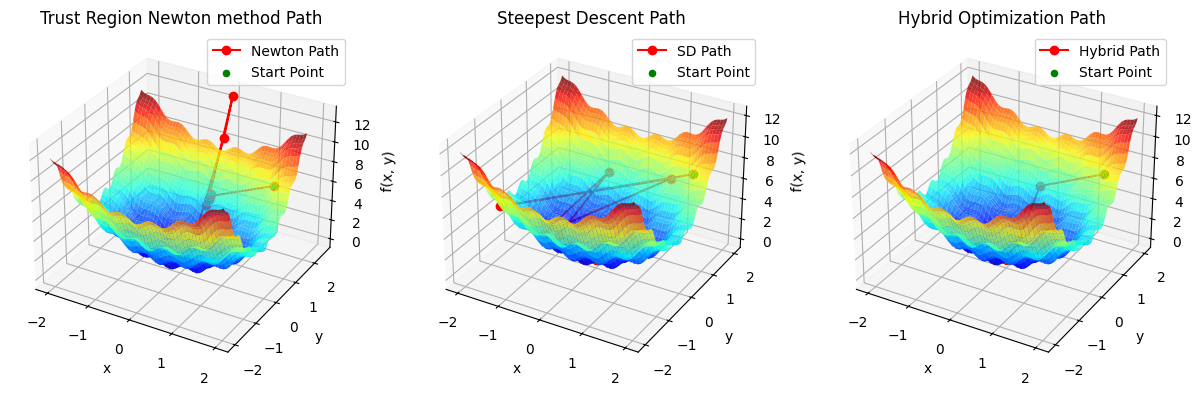

In [18]:
fig = plt.figure(figsize=(15, 5))

# 3D plot for Trust Region Newton method Path
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='jet', alpha=0.8)
ax1.plot(path_newton[:, 0], path_newton[:, 1], f1(path_newton[:, 0], path_newton[:, 1]), 'ro-', label='Newton Path')
ax1.scatter(x0[0], x0[1], f1(x0[0], x0[1]), color='green', label='Start Point')
ax1.set_title('Trust Region Newton method Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')
ax1.legend()

# 3D plot for Steepest Descent Path
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='jet', alpha=0.8)
ax2.plot(path_sd_armijo[:, 0], path_sd_armijo[:, 1], f1(path_sd_armijo[:, 0], path_sd_armijo[:, 1]), 'ro-', label='SD Path')
ax2.scatter(x0[0], x0[1], f1(x0[0], x0[1]), color='green', label='Start Point')
ax2.set_title('Steepest Descent Path')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('f(x, y)')
ax2.legend()

# 3D plot for Hybrid Optimization Path
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, Z, cmap='jet', alpha=0.8)
ax3.plot(path_sd_hybrid[:, 0], path_sd_hybrid[:, 1], f1(path_sd_hybrid[:, 0], path_sd_hybrid[:, 1]), 'ro-', label='Hybrid Path')
ax3.scatter(x0[0], x0[1], f1(x0[0], x0[1]), color='green', label='Start Point')
ax3.set_title('Hybrid Optimization Path')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('f(x, y)')
ax3.legend()

plt.show()